### Description

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sys.path.insert(0, os.path.join("..", "src"))
sys.path.insert(0, os.path.join("..", "examples"))

from augmentation import TransformData
from data_generators import generate_test_data_1
from tools import experiment, run_model_for_raw_and_augmented_data, smape

import warnings

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generating

In [9]:
df, train_test_split = generate_test_data_1()

## Let's look at the data
### there are some features x and some of them are correlated with target y

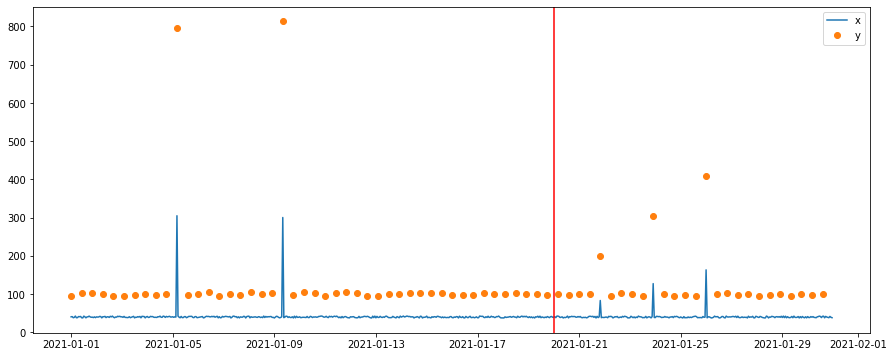

In [10]:
plt.figure(figsize=(15, 6))
x_cols = list(set(df.columns) - set(["time", "y"]))
for col in x_cols:
    plt.plot(df.time, df[col], label=col)
plt.plot(df.time, df.y, "o", markersize=6, label="y")
plt.axvline(train_test_split, color="red")
plt.legend()

## Run our model for augmented and not augmented data and store the result in pivot_result_table

In [11]:
default_model = RandomForestRegressor(n_estimators=200)
N_possible_values = range(8, 50, 2)
K_possible_values = range(6, 22, 1)

pivot_result_table = []
for n in N_possible_values:
    for k in K_possible_values:

        result_raw_data, result_augmented_data = experiment(
            model=default_model,
            df=df,
            train_test_split=train_test_split,
            N=n,
            K=k,
            tabgan=False,
        )

        pivot_result_table.append([n, k, result_raw_data, result_augmented_data])

pivot_result_table = pd.DataFrame(
    data=pivot_result_table,
    columns=["N", "K", "raw data smape", "augmented data smape"],
)

pivot_result_table.head(5)

,N,K,raw data mape,augmented data mape
0,8,6,0.116161,0.015440
1,8,7,0.116126,0.014630
2,8,8,0.116044,0.016420
3,8,9,0.116221,0.015170
4,8,10,0.116304,0.015226


## Let's look at the heatmap, and how the result depends on parameters N, K

<AxesSubplot:xlabel='K', ylabel='N'>

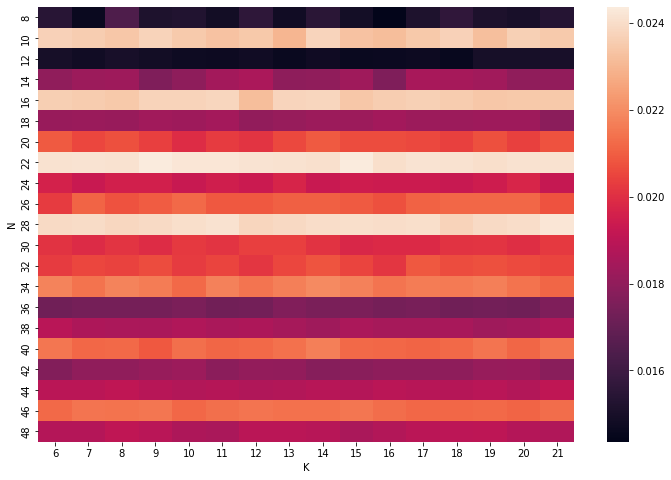

In [12]:
piv = pivot_result_table.pivot(index="N", columns="K", values="augmented data mape")
plt.figure(figsize=(12, 8))
sns.heatmap(piv)

#### In current example result essentially depends on "N" parameter and does not depend on "K" parameter
#### We could chouse best parameter automatically:

##### idx = pivot_result_table.sort_values('augmented data mape').iloc[:1].index
##### N = pivot_result_table.loc[idx,'N'].values[0]
##### K = pivot_result_table.loc[idx,'K'].values[0]
##### pivot_result_table.loc[idx,:]

#### but let’s do it manually, N=34, K=14

In [14]:
N = 10
K = 8

## Let’s run the current experiment one more time with optimal parameters

In [15]:
res = run_model_for_raw_and_augmented_data(default_model, df, train_test_split, N, K)
res.head(5)

Fitting CTGAN transformers for each column:   0%|          | 0/2 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

,time,y,pred_raw,pred_augm,pred_gan
456,2021-01-20 00:00:00,NaN,98.159248,98.094157,97.147811
457,2021-01-20 01:00:00,NaN,97.703349,97.938899,97.825155
458,2021-01-20 02:00:00,NaN,100.552677,100.572399,123.262691
459,2021-01-20 03:00:00,NaN,101.030721,101.581040,386.360360
460,2021-01-20 04:00:00,99.591528,101.030721,101.581040,386.360360


## Let's visualize the result

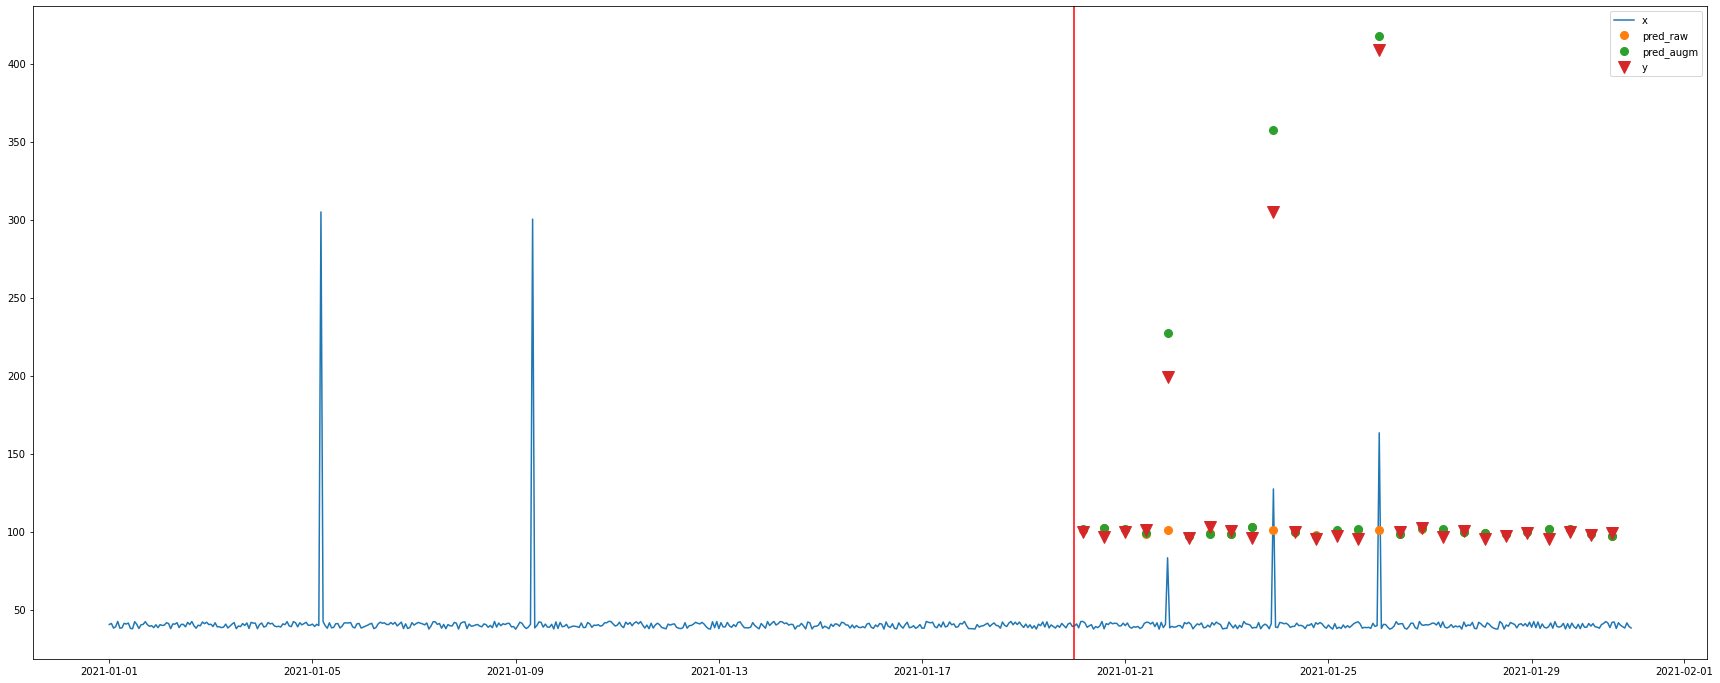

In [16]:
d = res[~np.isnan(res.y)]
plt.figure(figsize=(30, 12))
for col in x_cols:
    plt.plot(df.time, df[col], label=col)
plt.plot(d.time, d.pred_raw, "o", markersize=8, label="pred_raw")
plt.plot(d.time, d.pred_augm, "o", markersize=8, label="pred_augm")
plt.plot(d.time, d.y, "v", markersize=12, label="y")
plt.axvline(train_test_split, color="red")
plt.legend()
plt.show()